<a href="https://colab.research.google.com/github/vanijain07/ghg-emissions-prediction/blob/main/Prediction_of_GHG_Emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels

In [ ]:
!pip install pmdarima

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=8,4
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

Data collected from British Petroleum's Sustainability Reports

In [136]:
data1={'Date':['12/31/2000','12/31/2001','12/31/2002','12/31/2003','12/31/2004','12/31/2005','12/31/2006','12/31/2007','12/31/2008','12/31/2009','12/31/2010','12/31/2011','12/31/2012','12/31/2013','12/31/2014','12/31/2015','12/31/2016','12/31/2017','12/31/2018','12/31/2019','12/31/2020','12/31/2021','12/31/2022'],'Direct Greenhouse Gas Emission (MtCo2e)':[ 83.7,80.5,82.45,83.4,81.7,78.0,64.4,63.5,61.4,65.0,64.9,61.8,59.8,50.3,48.6,48.9,50.1,49.4,46.5,46.0,41.3,36.5,33.9]}

In [137]:
df=pd.DataFrame(data1)

In [138]:
df

,Date,Direct Greenhouse Gas Emission (MtCo2e)
0,12/31/2000,83.70
1,12/31/2001,80.50
2,12/31/2002,82.45
3,12/31/2003,83.40
4,12/31/2004,81.70
5,12/31/2005,78.00
6,12/31/2006,64.40
7,12/31/2007,63.50
8,12/31/2008,61.40
9,12/31/2009,65.00


Converting data to time series

In [139]:
df.index = pd.to_datetime(df['Date'], format='%m/%d/%Y')
del df['Date']

In [140]:
df.head()

,Direct Greenhouse Gas Emission (MtCo2e)
Date,
2000-12-31,83.70
2001-12-31,80.50
2002-12-31,82.45
2003-12-31,83.40
2004-12-31,81.70


In [141]:
sns.set()

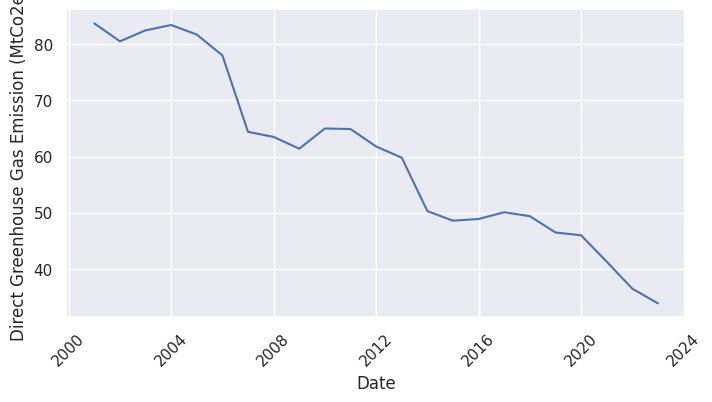

In [142]:
plt.ylabel('Direct Greenhouse Gas Emission (MtCo2e)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df.index, df['Direct Greenhouse Gas Emission (MtCo2e)'], )

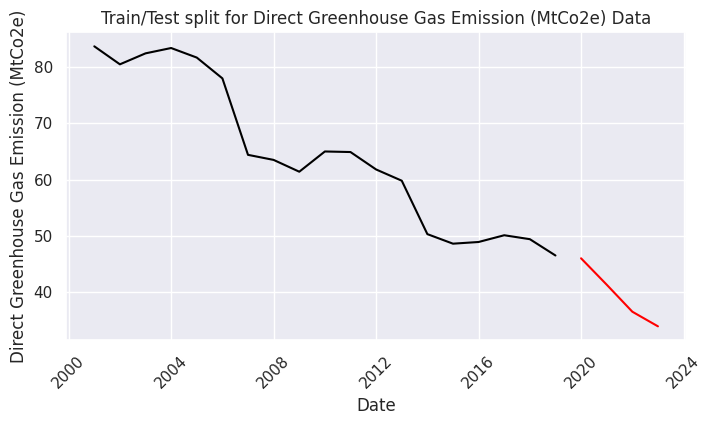

In [143]:
train = df[df.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = df[df.index > pd.to_datetime("2019-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Direct Greenhouse Gas Emission (MtCo2e)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Direct Greenhouse Gas Emission (MtCo2e) Data")
plt.show()

Evaluate Arima Model

In [144]:
def evaluate_arima_model(train,test,p,d,q):
    y = train['Direct Greenhouse Gas Emission (MtCo2e)']
    ARIMAmodel = ARIMA(y, order = (p, d, q))
    ARIMAmodel = ARIMAmodel.fit()

    y_pred = ARIMAmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    arma_rmse = np.sqrt(mean_squared_error(test["Direct Greenhouse Gas Emission (MtCo2e)"].values, y_pred_df["Predictions"]))
    return arma_rmse

Find optimal hyperparamets by Grid Search

In [145]:
def grid_search(train,test,p_max,d_max,q_max):
  best_p =None
  best_d =None
  best_q =None
  least_mse=float('inf')
  for p in range(p_max+1):
    for d in range(1,d_max+1):
      for q in range(q_max+1):
        warnings.filterwarnings("ignore")
        rmse=evaluate_arima_model(train,test,p,d,q)
        #print(p,d,q,rmse)
        if(rmse<least_mse):
          least_mse=rmse
          best_p =p
          best_d =d
          best_q =q

  return best_p,best_d,best_q,least_mse



In [146]:
p,d,q,mse=grid_search(train,test,5,5,3)

RMSE:  1.158155257163579


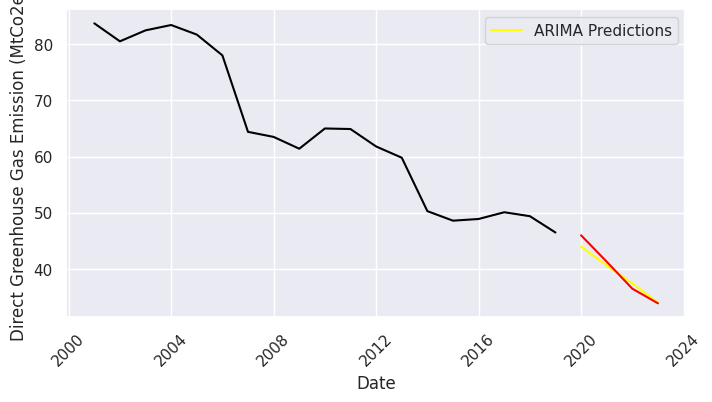

In [147]:
y = train['Direct Greenhouse Gas Emission (MtCo2e)']
ARIMAmodel = ARIMA(y, order = (p, d, q))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Direct Greenhouse Gas Emission (MtCo2e)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test["Direct Greenhouse Gas Emission (MtCo2e)"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

**`Prediction for next 5 years `**

In [148]:
def predict(df,p,d,q):
  future={'Date':['12/31/2023','12/31/2024','12/31/2025','12/31/2026','12/31/2027','12/31/2028']}
  df_future=pd.DataFrame(future)
  df_future.index = pd.to_datetime(df_future['Date'], format='%m/%d/%Y')
  del df_future['Date']
  y = df['Direct Greenhouse Gas Emission (MtCo2e)']
  ARIMAmodel = ARIMA(y, order = (p, d, q))
  ARIMAmodel = ARIMAmodel.fit()

  y_pred = ARIMAmodel.get_forecast(len(df_future.index))
  y_pred_df = y_pred.conf_int(alpha = 0.05)
  y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
  y_pred_df.index = df_future.index
  y_pred_out = y_pred_df["Predictions"]
  plt.plot(y_pred_out, color='blue', label = 'ARIMA Predictions')
  plt.plot(df, color = "black")
  plt.ylabel('Direct Greenhouse Gas Emission (MtCo2e)')
  plt.xlabel('Date')
  plt.xticks(rotation=45)
  plt.legend()


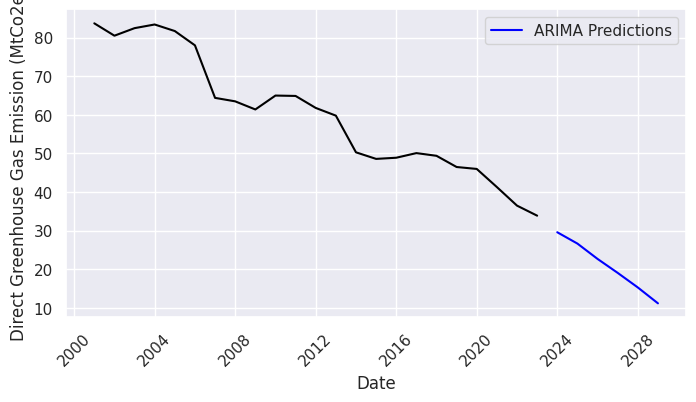

In [149]:
predict(df,p,d,q)

# GHG Emission of India

Loading dataset

In [150]:
url='https://raw.githubusercontent.com/vanijain07/ghg-emissions-prediction/main/total-ghg-emissions.csv'
data=pd.read_csv(url)

In [151]:
data.head()

,Entity,Code,Year,Annual greenhouse gas emissions in CO2 equivalents
0,Afghanistan,AFG,1850,7299493.5
1,Afghanistan,AFG,1851,7373215.0
2,Afghanistan,AFG,1852,7422393.5
3,Afghanistan,AFG,1853,7483596.0
4,Afghanistan,AFG,1854,7532321.5


In [152]:
#country for which predictions need to be found
country="India"

In [153]:
df_2 = data[data['Entity'] == country].copy()

In [154]:
#Choosing data from 1990 onwards
df_2 = df_2[df_2['Year'] >= 1990]

Converting data to time series

In [155]:
df_2['Month']=12
df_2['Day']=31
df_2=df_2.drop(['Entity','Code'],axis=1)
df_2.index = pd.to_datetime(df_2[['Year','Month','Day']])
df_2.index.names = ['Date']
df_2=df_2.drop(['Year','Month','Day'],axis=1)

In [156]:
df_2.head()

,Annual greenhouse gas emissions in CO2 equivalents
Date,
1990-12-31,1.533376e+09
1991-12-31,1.577598e+09
1992-12-31,1.636317e+09
1993-12-31,1.649160e+09
1994-12-31,1.685452e+09


In [157]:
df_2.tail()

,Annual greenhouse gas emissions in CO2 equivalents
Date,
2017-12-31,3.621199e+09
2018-12-31,3.783796e+09
2019-12-31,3.815780e+09
2020-12-31,3.638071e+09
2021-12-31,3.900927e+09


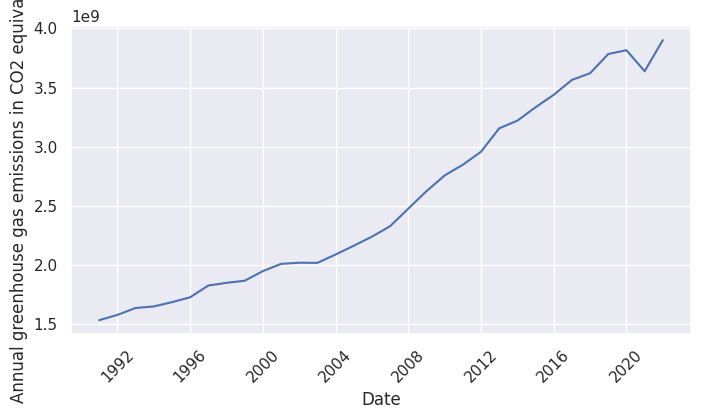

In [158]:
plt.ylabel('Annual greenhouse gas emissions in CO2 equivalents')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df_2.index, df_2['Annual greenhouse gas emissions in CO2 equivalents'], )

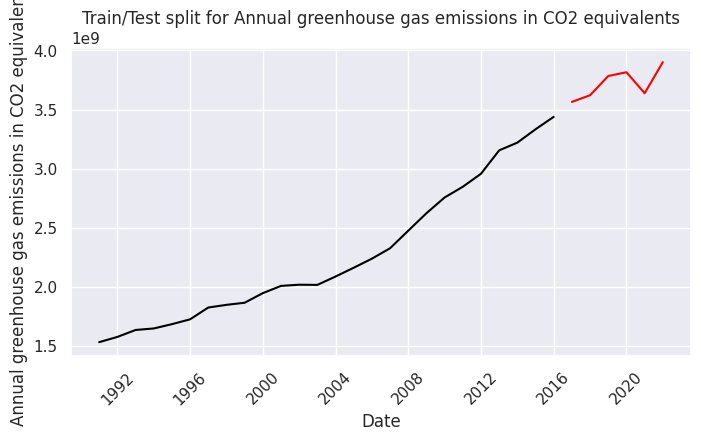

In [159]:
train_2 = df_2[df_2.index < pd.to_datetime("2016-01-01", format='%Y-%m-%d')]
test_2 = df_2[df_2.index > pd.to_datetime("2016-01-01", format='%Y-%m-%d')]

plt.plot(train_2, color = "black")
plt.plot(test_2, color = "red")
plt.ylabel('Annual greenhouse gas emissions in CO2 equivalents')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Annual greenhouse gas emissions in CO2 equivalents")
plt.show()

Evaluate ARIMA Model

In [160]:
def evaluate_arima_model_2(train,test,p,d,q):
    y = train['Annual greenhouse gas emissions in CO2 equivalents']
    ARIMAmodel = ARIMA(y, order = (p, d, q))
    ARIMAmodel = ARIMAmodel.fit()

    y_pred = ARIMAmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    arma_rmse = np.sqrt(mean_squared_error(test["Annual greenhouse gas emissions in CO2 equivalents"].values, y_pred_df["Predictions"]))
    return arma_rmse

Find optimal hyperparamets by Grid Search

In [161]:
def grid_search_2(train,test,p_max,d_max,q_max):
  best_p =None
  best_d =None
  best_q =None
  least_mse=float('inf')
  for p in range(p_max+1):
    for d in range(1,d_max+1):
      for q in range(q_max+1):
        warnings.filterwarnings("ignore")
        rmse=evaluate_arima_model_2(train,test,p,d,q)
        #print(p,d,q,rmse)
        if(rmse<least_mse):
          least_mse=rmse
          best_p =p
          best_d =d
          best_q =q

  return best_p,best_d,best_q,least_mse


In [162]:
p,d,q,mse=grid_search_2(train_2,test_2,5,5,5)

RMSE:  91365669.1370668


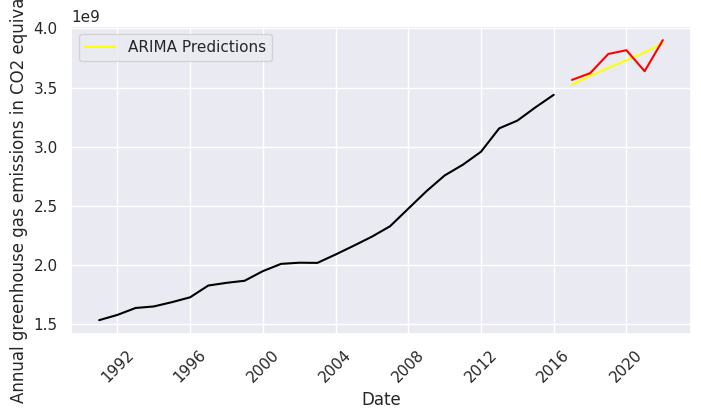

In [163]:
y = train_2['Annual greenhouse gas emissions in CO2 equivalents']
ARIMAmodel = ARIMA(y, order = (p, d, q))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test_2.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_2.index
y_pred_out = y_pred_df["Predictions"]
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train_2, color = "black")
plt.plot(test_2, color = "red")
plt.ylabel('Annual greenhouse gas emissions in CO2 equivalents')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()


arma_rmse = np.sqrt(mean_squared_error(test_2["Annual greenhouse gas emissions in CO2 equivalents"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

**Future Prediction**

In [164]:
def predict_future(df,p,d,q):
  future={'Date':['12/31/2023','12/31/2024','12/31/2025','12/31/2026','12/31/2027','12/31/2028','12/31/2029','12/31/2030','12/31/2031','12/31/2032','12/31/2033','12/31/2034','12/31/2035']}
  df_future=pd.DataFrame(future)
  df_future.index = pd.to_datetime(df_future['Date'], format='%m/%d/%Y')
  del df_future['Date']
  y = df['Annual greenhouse gas emissions in CO2 equivalents']
  ARIMAmodel = ARIMA(y, order = (p, d, q))
  ARIMAmodel = ARIMAmodel.fit()

  y_pred = ARIMAmodel.get_forecast(len(df_future.index))
  y_pred_df = y_pred.conf_int(alpha = 0.05)
  y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
  y_pred_df.index = df_future.index
  y_pred_out = y_pred_df["Predictions"]
  print(y_pred_df)
  plt.plot(y_pred_out, color='blue', label = 'ARIMA Predictions')
  plt.plot(df, color = "black")
  plt.ylabel('Annual greenhouse gas emissions in CO2 equivalents')
  plt.xlabel('Date')
  plt.xticks(rotation=45)
  plt.legend()


            lower Annual greenhouse gas emissions in CO2 equivalents  \
Date                                                                   
2023-12-31                                       3.796936e+09          
2024-12-31                                       3.819766e+09          
2025-12-31                                       3.839685e+09          
2026-12-31                                       3.859601e+09          
2027-12-31                                       3.912910e+09          
2028-12-31                                       3.926797e+09          
2029-12-31                                       3.987058e+09          
2030-12-31                                       4.015539e+09          
2031-12-31                                       4.059177e+09          
2032-12-31                                       4.113579e+09          
2033-12-31                                       4.138751e+09          
2034-12-31                                       4.206958e+09   

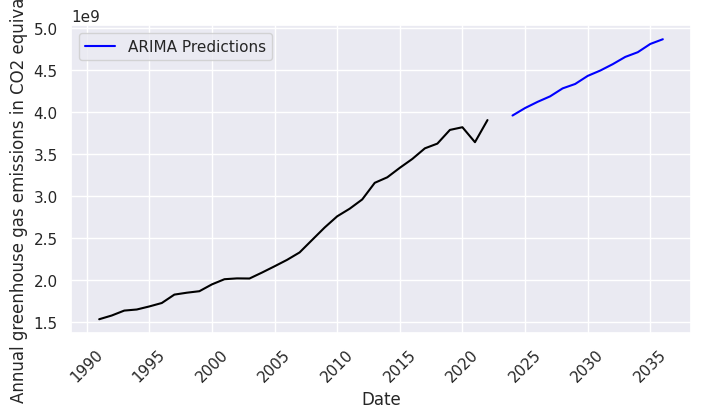

In [165]:
predict_future(df_2,p,d,q)

# Air Quality Index Prediction for Delhi

In [166]:
url_2='https://raw.githubusercontent.com/vanijain07/ghg-emissions-prediction/main/city_day.csv'
df_3 = pd.read_csv(url_2)
df_3_delhi = df_3.loc[df_3['City'] == 'Delhi']

In [167]:
#converting data to time series
df_delhi = df_3_delhi[['Date','AQI']]
df_delhi.index = pd.to_datetime(df_delhi['Date'], format='%Y-%m-%d')
del df_delhi['Date']

In [168]:
#dropping null values
df_delhi = df_delhi.dropna()

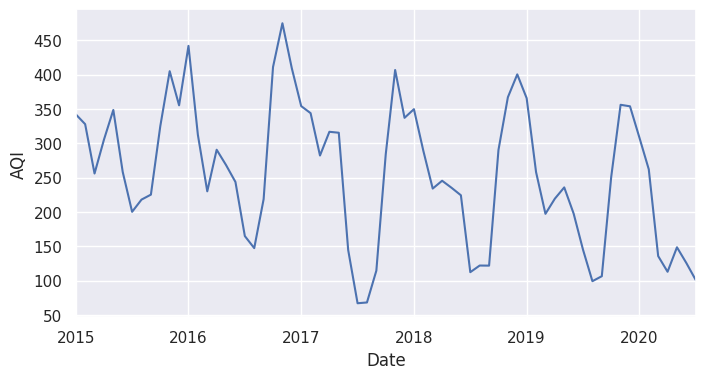

In [169]:
#converting data from daily to monthly
df_month_avg = df_delhi['AQI'].resample('MS').mean()
df_month_avg.plot()
plt.ylabel('AQI')
plt.xlabel('Date')
plt.show()

Text(0.5, 0, 'Date')

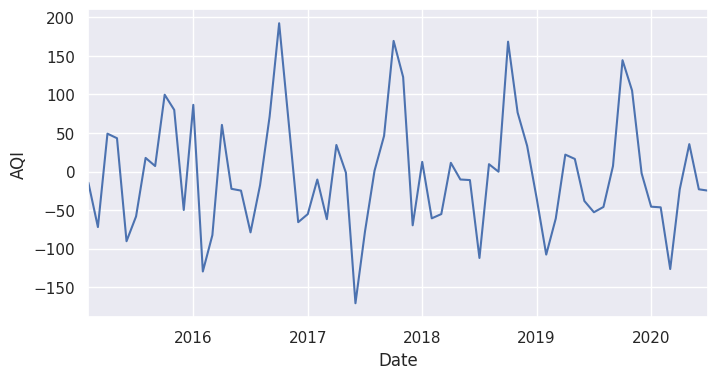

In [170]:
#removing the trend
df_trend_adj = df_month_avg - df_month_avg.shift(1)
df_trend_adj = df_trend_adj.dropna()
df_trend_adj.plot()
plt.ylabel('AQI')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

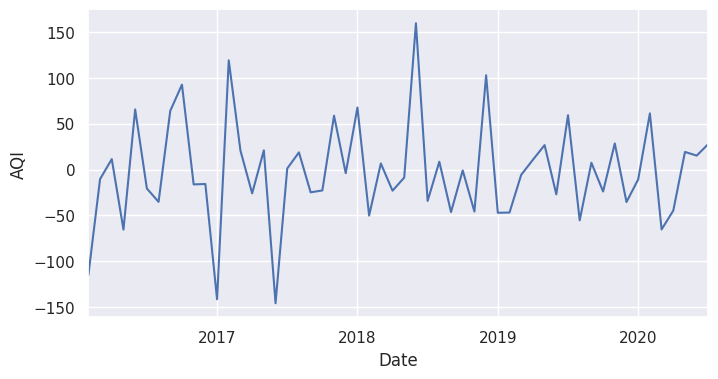

In [171]:
#removing seasonality
df_seasonal_adj = df_trend_adj - df_trend_adj.shift(12)
df_seasonal_adj = df_seasonal_adj.dropna()
df_seasonal_adj.plot()
plt.ylabel('AQI')
plt.xlabel('Date')

Finding optimal hyperparameters by grid search

In [172]:
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
aic_min=float('inf')
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(df_seasonal_adj,order=i,seasonal_order=j,enforce_stationarity=False,enforce_invertibility=False)
            results = model.fit()
            if(results.aic<aic_min):
              aic_min=results.aic
              pdq_min=i
              seasonal_pdq_min=j
        except:
            continue

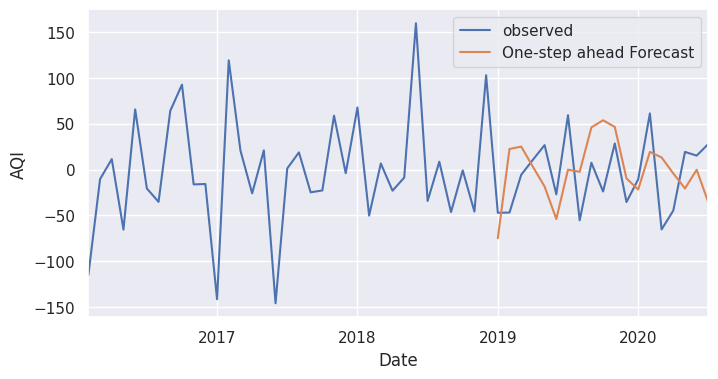

In [173]:
sarima=SARIMAX(df_seasonal_adj,order=pdq_min,seasonal_order=seasonal_pdq_min)
result=sarima.fit()
pred = result.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
obs = df_seasonal_adj.plot(label='observed')
pred.predicted_mean.plot(ax=obs, label='One-step ahead Forecast')
obs.set_xlabel('Date')
obs.set_ylabel('AQI')
plt.legend()
plt.show()

In [174]:
y_pred = pred.predicted_mean
y_obs = df_seasonal_adj['2019-01-01':]
rmse = np.sqrt(mean_squared_error(y_obs,y_pred))
print("RMSE: ",rmse)

RMSE:  45.81528715195659


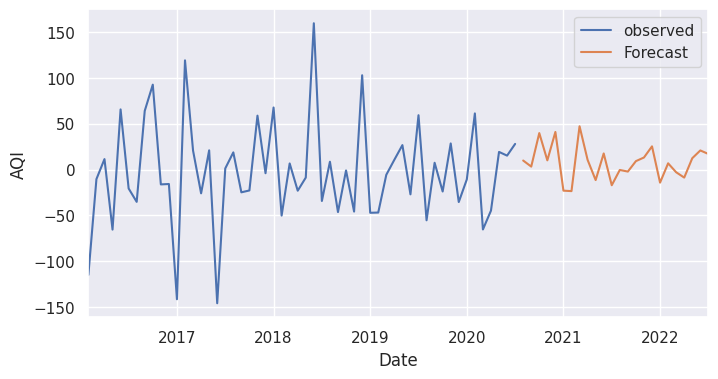

In [175]:
forecast = result.get_forecast(steps = 24)
forecast_ci = forecast.conf_int()
obs = df_seasonal_adj.plot(label='observed')
forecast.predicted_mean.plot(ax=obs, label='Forecast')
obs.set_xlabel('Date')
obs.set_ylabel('AQI')
plt.legend()
plt.show()